## Set up model 

Set up a Keras model (you may find it helpful to keep it simple and fast to train). Train on an intermediate-sized dataset (if you are using MNIST, say 2000 or 4000). 


Plot the loss and error rate as a function of training epochs. 


###  1.  Assessment of initial model: The Percolation Dataset

Ensure that your model is complex enough to *overfit* the training data: that is the loss/error-rate on the training set should be below your target loss/error-rate, and the loss/error-rate on the validation set should be higher than this (preferably higher than your target error-rate). 

In [1]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
from random import randint

In [2]:
def percolate( mat ):
    """
    Returns True if there is a percolation path of 1s from col 0 col -1 of a matrix of 0s and 1s
    """
    nrows = mat.shape[0]
    ncols = mat.shape[1]
    frontier = set()
    for i in range(0,nrows):
        if mat[i,0]:
            frontier.add( (i,0) )
    explored = set()
    flag = False # this will be returned if the frontier becomes empty without finding a
                 # filled pixel in the right-most column
    while frontier: # frontier evaluates to True in this context if it is non-empty
        r,c = frontier.pop()
        explored.add( (r,c) )
        if r > 0: # North
            if mat[r-1,c]:
                coords = (r-1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c < ncols-1: # East
            if mat[r,c+1]:
                if c+1 == mat.shape[1]-1 : # Hurray, we have percolated to the last column
                    flag = True
                    break
                coords = (r,c+1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if r < nrows-1: # South
            if mat[r+1,c]:
                coords = (r+1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c > 0: # West
            if mat[r,c-1]:
                coords = (r,c-1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
    return flag

In [3]:
def make_percolation_dataset(side=8,threshold=0.42,n_examples=10):
    """
    This function generates an array of random images, in the form needed for Keras, and 
    then labels them as percolating or not, using the percolate function. Roughly 50% of the
    images will have class 1 (percolating), so the dataset is likely to be reasonably balanced. 
    """
    X_data = (np.random.random([n_examples,side,side,1]) > threshold).astype(float) 
    Y_data = np.zeros([n_examples,1])
    for i in range(0,n_examples):
        if percolate(X_data[i,:,:,0]):
            Y_data[i,0] = 1
    return (X_data,Y_data)

In [4]:
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Conv2D 

from tensorflow.python.keras.models import Sequential

import tensorflow.python.keras.regularizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.regularizers import l1,l2

In [5]:
training_set,training_classes = make_percolation_dataset(side=8, threshold=0.42, n_examples=32000)
validation_set, validation_classes = make_percolation_dataset(side=8, threshold=0.42, n_examples=10000)

In [6]:
np.sum(training_classes)

15377.0

In [7]:
model_dense = Sequential()
model_dense.add(Flatten(input_shape=(8,8,1))) # converts each image to a 1D array of values
model_dense.add(Dense(300,activation='relu'))
model_dense.add(Dense(1,activation='sigmoid'))
model_dense.summary()
model_dense.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 300)               19500     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 19,801
Trainable params: 19,801
Non-trainable params: 0
_________________________________________________________________


In [8]:
train_size = 8000
history = model_dense.fit(training_set[:train_size,:,:,:],training_classes[:train_size,:],
                          batch_size=32,epochs=50,shuffle=True,verbose=1, 
                          validation_data=(validation_set, validation_classes))

Train on 8000 samples, validate on 10000 samples
Epoch 1/50
8000/8000 [==============================] - 3s 314us/step - loss: 0.6633 - acc: 0.5998 - val_loss: 0.6302 - val_acc: 0.6654
Epoch 2/50
8000/8000 [==============================] - 1s 106us/step - loss: 0.6110 - acc: 0.6783 - val_loss: 0.6206 - val_acc: 0.6459
Epoch 3/50
8000/8000 [==============================] - 1s 106us/step - loss: 0.5720 - acc: 0.7199 - val_loss: 0.5715 - val_acc: 0.7156
Epoch 4/50
8000/8000 [==============================] - 1s 107us/step - loss: 0.5364 - acc: 0.7416 - val_loss: 0.5521 - val_acc: 0.7203
Epoch 5/50
8000/8000 [==============================] - 1s 109us/step - loss: 0.5024 - acc: 0.7634 - val_loss: 0.5582 - val_acc: 0.7074
Epoch 6/50
8000/8000 [==============================] - 1s 106us/step - loss: 0.4804 - acc: 0.7738 - val_loss: 0.5310 - val_acc: 0.7297
Epoch 7/50
8000/8000 [==============================] - 1s 107us/step - loss: 0.4559 - acc: 0.7868 - val_loss: 0.5274 - val_acc: 0.7384

In [9]:
res_test = model_dense.evaluate(validation_set,validation_classes,batch_size=32)
print('Validation Error rate=',(1-res_test[1])*100,'%')

10000/10000 [==============================] - 0s 27us/step
Validation Error rate= 27.049999999999997 %


In [10]:
res_train = model_dense.evaluate(training_set[:train_size,:,:,:],training_classes[:train_size,:])
print('Train Error rate=',(1-res_train[1])*100,'%')

8000/8000 [==============================] - 0s 25us/step
Train Error rate= 0.4375000000000018 %


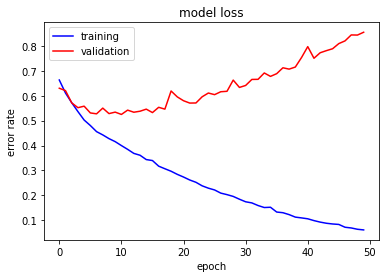

In [11]:
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'r')
plt.title('model loss')
plt.ylabel('error rate')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

The graph above shows clearly that there is overfitting in the model. 
As the error rate for training set decreases with number of epochs but the error rate for the validation set first decreases to a minimum value and then increases gradualy with increase in the number of epochs.

##### Validation Error rate= 27.049999999999997 %
##### Train Error rate= 0.4375000000000018 %

### 2.  Regularisation experiment:  

Now select a type of regularisation (which may be L2, L1, L12, or dropout) and train your initial model with different amounts of regularisation. 

A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse. 

Train your model multiple times, applying different amounts of regularisation, and plot a graoph showing the effect of different amounts of regularisation. 

Plot the amount of regularisation along the x axis, and the validation set performance (loss/error-rate) on the y axis.  How does regularisation affect the performance of your initial network, and what is the optimal amount? 

In [13]:
# Performing L2 regularization with different values of lambda
l2_val = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
loss_val = []

for i in l2_val:
    model_dense = Sequential()
    model_dense.add(Flatten(input_shape=(8,8,1))) # converts each image to a 1D array of values
    model_dense.add(Dense(300,activation='relu',kernel_regularizer=l2(i)))
    model_dense.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(i)))
    model_dense.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    train_size = 8000
    history = model_dense.fit(training_set[:train_size,:,:,:],training_classes[:train_size,:],
                          batch_size=32,epochs=50,shuffle=True,verbose=0, 
                          validation_data=(validation_set, validation_classes))
    
    
    print('Error rate with L2-regularization(',i,')=')
    res_test = model_dense.evaluate(validation_set,validation_classes,batch_size=32,verbose=0)
    print('Validation Error rate=',(1-res_test[1])*100,'%')
    loss_val.append((1-res_test[1])*100)
    res_train = model_dense.evaluate(training_set[:train_size,:,:,:],training_classes[:train_size,:],verbose=0)
    print('Train Error rate=',(1-res_train[1])*100,'%')
    print()

Error rate with L2-regularization( 0.1 )=
Validation Error rate= 48.4 %
Train Error rate= 47.35 %

Error rate with L2-regularization( 0.01 )=
Validation Error rate= 27.93 %
Train Error rate= 28.049999999999997 %

Error rate with L2-regularization( 0.001 )=
Validation Error rate= 26.349999999999994 %
Train Error rate= 11.650000000000006 %

Error rate with L2-regularization( 0.0001 )=
Validation Error rate= 26.780000000000005 %
Train Error rate= 2.4249999999999994 %

Error rate with L2-regularization( 1e-05 )=
Validation Error rate= 27.339999999999996 %
Train Error rate= 0.7125000000000048 %

Error rate with L2-regularization( 1e-06 )=
Validation Error rate= 26.74 %
Train Error rate= 0.31250000000000444 %



In [14]:
loss_val

[48.4,
 27.93,
 26.349999999999994,
 26.780000000000005,
 27.339999999999996,
 26.74]

Text(0.5,0,'regularisation amount')

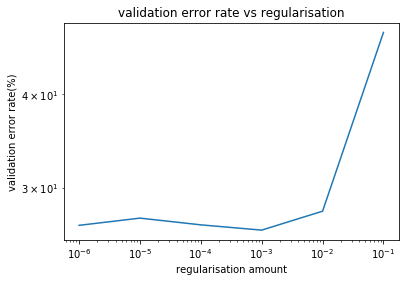

In [16]:
plt.loglog(l2_val,loss_val)
plt.title('validation error rate vs regularisation')
plt.ylabel('validation error rate(%)')
plt.xlabel('regularisation amount')

#### As seen from the graph above the validation error rate is minimum at Lambda= 0.001. Therefore using 0.001 for choosing the training size in section 3.

### 3.  Learning curve experiment:  

Now train your model (with the amount of regularisation you selected) on different amounts of training data. 

Plot the performance (loss/error-rate) of the model on the validation set against the size of the training set. 
This is typically best done on a log-log plot. 

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ? 

For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is. 

In [17]:
# Learning curve with regularization=0.001
train_size_val = [2000,4000,8000,16000,32000]
loss_val = []

for i in train_size_val:
    model_dense = Sequential()
    model_dense.add(Flatten(input_shape=(8,8,1))) # converts each image to a 1D array of values
    model_dense.add(Dense(300,activation='relu',kernel_regularizer=l2(0.001)))
    model_dense.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(0.001)))
    model_dense.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    history = model_dense.fit(training_set[:i,:,:,:],training_classes[:i,:],
                          batch_size=32,epochs=50,shuffle=True,verbose=0, 
                          validation_data=(validation_set, validation_classes))
    
    
    print('Error rate with Training size(',i,')=')
    res_test = model_dense.evaluate(validation_set,validation_classes,batch_size=32,verbose=0)
    print('Validation Error rate=',(1-res_test[1])*100,'%')
    loss_val.append((1-res_test[1])*100)
    res_train = model_dense.evaluate(training_set[:train_size,:,:,:],training_classes[:train_size,:],verbose=0)
    print('Train Error rate=',(1-res_train[1])*100,'%')
    print()

Error rate with Training size( 2000 )=
Validation Error rate= 31.35 %
Train Error rate= 23.750000000000004 %

Error rate with Training size( 4000 )=
Validation Error rate= 28.810000000000002 %
Train Error rate= 17.062500000000004 %

Error rate with Training size( 8000 )=
Validation Error rate= 27.1 %
Train Error rate= 12.8 %

Error rate with Training size( 16000 )=
Validation Error rate= 26.049999999999997 %
Train Error rate= 17.774999999999995 %

Error rate with Training size( 32000 )=
Validation Error rate= 26.459999999999994 %
Train Error rate= 21.662499999999994 %



Text(0.5,0,'train size')

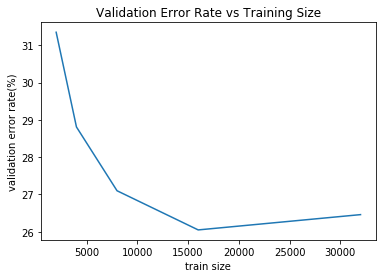

In [21]:
plt.plot(train_size_val,loss_val)
plt.title('Validation Error Rate vs Training Size')
plt.ylabel('validation error rate(%)')
plt.xlabel('train size')

From the graph above it is evident that the error rate is least when the training size=16000

### 4. Second model:   

Devise what you believe to be a better neural network architecture for the problem (e.g. for MNIST you might use a fully-connected network for your initial model, and then try a convolutional net for your second model).

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data). 

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model?  

# Complex model with CNN

In [22]:
model = Sequential()
model.add(Conv2D(36,(3,3),activation='relu',padding='same',input_shape=(8,8,1)))
model.add(Conv2D(36,(1,1),activation='relu',padding='same'))
#model.add(Dropout(0.1))
model.add(Conv2D(48,(3,3),activation='relu',padding='valid')) # reduces the grid size to 6x6
#model.add(Dropout(0.25))
model.add(Conv2D(48,(3,3),activation='relu',padding='valid')) # reduces the grid size to 4x4
#model.add(Dropout(0.25))
model.add(Conv2D(96,(3,3),activation='relu',padding='valid')) # reduces the grid size to 2x2
#model.add(Dropout(0.25))
model.add(Flatten()) # transforms layout to all 4x36=144 neurons to a line
model.add(Dense(20,activation='relu'))  # 20 neurons each connected to all 144 previous neurons
model.add(Dense(20,activation='relu'))  # 20 neurons each connsected to all 20 previous neurons
model.add(Dense(1,activation='sigmoid')) 
# one single logistic output neuron giving estimated probability of percolation

In [23]:
model.summary()
sgd = SGD(lr=0.01, decay=1e-6,momentum=0.9, nesterov=True)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
train_size = 8000
history = model.fit(training_set[:train_size,:,:,:],training_classes[:train_size,:],
                          batch_size=32,epochs=50,shuffle=True,verbose=1, 
                          validation_data=(validation_set, validation_classes))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 36)          360       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 36)          1332      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 48)          15600     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 48)          20784     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 96)          41568     
_________________________________________________________________
flatten_18 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 20)                7700      
__________

10000/10000 [==============================] - 0s 43us/step
Validation Error rate= 0.8499999999999952 %
8000/8000 [==============================] - 0s 39us/step
Train Error rate= 0.0 %


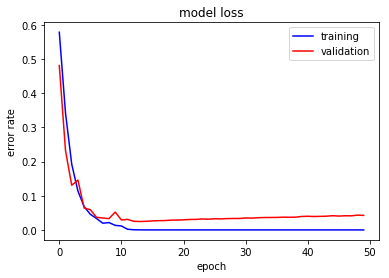

In [24]:
res_test = model.evaluate(validation_set,validation_classes,batch_size=32)
print('Validation Error rate=',(1-res_test[1])*100,'%')
res_train = model.evaluate(training_set[:train_size,:,:,:],training_classes[:train_size,:])
print('Train Error rate=',(1-res_train[1])*100,'%')
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'r')
plt.title('model loss')
plt.ylabel('error rate')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

Really good model, doesn't overfits as seen from the graph above

In [28]:
# L2 regularization & dropout
l2_val = [0.1,0.01,0.001,0.0001,0.00001,0.000001]
loss_val = []

for i in l2_val:
    model = Sequential()
    model.add(Conv2D(36,(3,3),activation='relu',padding='same',input_shape=(8,8,1), kernel_regularizer=l2(i)))
    model.add(Conv2D(36,(1,1),activation='relu',padding='same', kernel_regularizer=l2(i)))
    #model.add(Dropout(0.1))
    model.add(Conv2D(48,(3,3),activation='relu',padding='valid', kernel_regularizer=l2(i))) # reduces the grid size to 6x6
    model.add(Dropout(0.25))
    model.add(Conv2D(48,(3,3),activation='relu',padding='valid', kernel_regularizer=l2(i))) # reduces the grid size to 4x4
    model.add(Dropout(0.25))
    model.add(Conv2D(96,(3,3),activation='relu',padding='valid', kernel_regularizer=l2(i))) # reduces the grid size to 2x2
    model.add(Dropout(0.25))
    model.add(Flatten()) # transforms layout to all 4x36=144 neurons to a line
    model.add(Dense(20,activation='relu',kernel_regularizer=l2(i)))  # 20 neurons each connected to all 144 previous neurons
    model.add(Dense(20,activation='relu',kernel_regularizer=l2(i)))  # 20 neurons each connsected to all 20 previous neurons
    model.add(Dense(1,activation='sigmoid')) 
    #model.summary()
    sgd = SGD(lr=0.01, decay=1e-6,momentum=0.9, nesterov=True)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    train_size = 8000
    history = model.fit(training_set[:train_size,:,:,:],training_classes[:train_size,:],
                          batch_size=32,epochs=50,shuffle=True,verbose=0, 
                          validation_data=(validation_set, validation_classes))
    
    
    print('Error rate with L2-regularization(',i,')=')
    res_test = model.evaluate(validation_set,validation_classes,batch_size=32,verbose=0)
    print('Validation Error rate=',(1-res_test[1])*100,'%')
    loss_val.append((1-res_test[1])*100)
    res_train = model.evaluate(training_set[:train_size,:,:,:],training_classes[:train_size,:],verbose=0)
    print('Train Error rate=',(1-res_train[1])*100,'%')
    print()

Error rate with L2-regularization( 0.1 )=
Validation Error rate= 48.4 %
Train Error rate= 47.35 %

Error rate with L2-regularization( 0.01 )=
Validation Error rate= 48.4 %
Train Error rate= 47.35 %

Error rate with L2-regularization( 0.001 )=
Validation Error rate= 1.1299999999999977 %
Train Error rate= 0.5249999999999977 %

Error rate with L2-regularization( 0.0001 )=
Validation Error rate= 0.42999999999999705 %
Train Error rate= 0.03750000000000142 %

Error rate with L2-regularization( 1e-05 )=
Validation Error rate= 0.47000000000000375 %
Train Error rate= 0.0 %

Error rate with L2-regularization( 1e-06 )=
Validation Error rate= 0.5900000000000016 %
Train Error rate= 0.04999999999999449 %



Text(0.5,0,'regularisation amount')

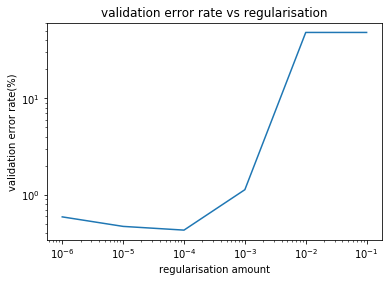

In [29]:
plt.loglog(l2_val,loss_val)
plt.title('validation error rate vs regularisation')
plt.ylabel('validation error rate(%)')
plt.xlabel('regularisation amount')

Selecting Lambda=0.00001

In [32]:
# Learning curve
train_size_val = [2000,4000,8000,16000,32000]
loss_val = []

for i in train_size_val:
    model = Sequential()
    model.add(Conv2D(36,(3,3),activation='relu',padding='same',input_shape=(8,8,1), kernel_regularizer=l2(0.00001)))
    model.add(Conv2D(36,(1,1),activation='relu',padding='same', kernel_regularizer=l2(0.00001)))
    #model.add(Dropout(0.1))
    model.add(Conv2D(48,(3,3),activation='relu',padding='valid', kernel_regularizer=l2(0.00001))) # reduces the grid size to 6x6
    model.add(Dropout(0.25))
    model.add(Conv2D(48,(3,3),activation='relu',padding='valid', kernel_regularizer=l2(0.00001))) # reduces the grid size to 4x4
    model.add(Dropout(0.25))
    model.add(Conv2D(96,(3,3),activation='relu',padding='valid', kernel_regularizer=l2(0.00001))) # reduces the grid size to 2x2
    model.add(Dropout(0.25))
    model.add(Flatten()) # transforms layout to all 4x36=144 neurons to a line
    model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.00001)))  # 20 neurons each connected to all 144 previous neurons
    model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.00001)))  # 20 neurons each connsected to all 20 previous neurons
    model.add(Dense(1,activation='sigmoid')) 
    #model.summary()
    sgd = SGD(lr=0.01, decay=1e-6,momentum=0.9, nesterov=True)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    history = model_dense.fit(training_set[:i,:,:,:],training_classes[:i,:],
                          batch_size=32,epochs=50,shuffle=True,verbose=0, 
                          validation_data=(validation_set, validation_classes))
    
    
    print('Error rate with Training size(',i,')=')
    res_test = model_dense.evaluate(validation_set,validation_classes,batch_size=32,verbose=0)
    print('Validation Error rate=',(1-res_test[1])*100,'%')
    loss_val.append((1-res_test[1])*100)
    res_train = model_dense.evaluate(training_set[:train_size,:,:,:],training_classes[:train_size,:],verbose=0)
    print('Train Error rate=',(1-res_train[1])*100,'%')
    print()

Error rate with Training size( 2000 )=
Validation Error rate= 28.63 %
Train Error rate= 18.275 %

Error rate with Training size( 4000 )=
Validation Error rate= 28.720000000000002 %
Train Error rate= 14.312499999999995 %

Error rate with Training size( 8000 )=
Validation Error rate= 26.900000000000002 %
Train Error rate= 8.387500000000003 %

Error rate with Training size( 16000 )=
Validation Error rate= 26.400000000000002 %
Train Error rate= 14.825 %

Error rate with Training size( 32000 )=
Validation Error rate= 27.71 %
Train Error rate= 23.5375 %



Text(0.5,0,'train size')

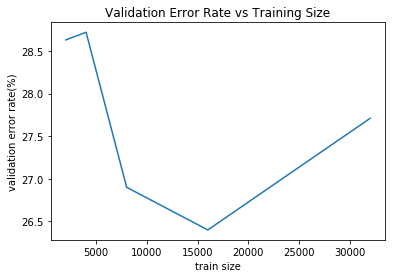

In [33]:
plt.plot(train_size_val,loss_val)
plt.title('Validation Error Rate vs Training Size')
plt.ylabel('validation error rate(%)')
plt.xlabel('train size')

Again the error rate is least when the training size=16000. The learning curve is almost similar.